In [1]:
import sys

sys.path.insert(0, '../')
from nnsight import LanguageModel
import pandas as pd
import torch as t
import torch.nn as nn
from attribution import patching_effect
from dictionary_learning import AutoEncoder, ActivationBuffer
from dictionary_learning.interp import examine_dimension
from dictionary_learning.utils import zst_to_generator

/share/u/smarks/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Matplotlib created a temporary cache directory at /tmp/matplotlib-7g0minf6 because the default path (/share/u/smarks/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
device = 'cuda:0'

model = LanguageModel('EleutherAI/pythia-70m-deduped', device_map=device)
layer = 4

threshold_low = 0.2
threshold_high = 0.7
sp_feature = 'muslim'

batch_size = 64

SEED = 42

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [32]:
# prepare batched data
def batch(statements, f_labels, sp_labels, layer, batch_size=64, device='cpu'):
    batches = []
    for i in range(0, len(statements), batch_size):
        with model.invoke(statements[i:i+batch_size]):
            acts = model.gpt_neox.layers[layer].output[0][:, -1, :].save()
        batches.append((
            acts.value.to(device),
            t.tensor(f_labels[i:i+batch_size], device=device),
            t.tensor(sp_labels[i:i+batch_size], device=device)
        ))
    return batches


data = {'train' : {}, 'test' : {}}
statements, f_labels, sp_labels = prepare_data(threshold_low, threshold_high, sp_feature, ambiguous=False, split='train', seed=SEED)
data['train']['unambiguous'] = {
    'statements': statements,
    'f_labels': f_labels,
    'sp_labels': sp_labels,
    'batches': batch(statements, f_labels, sp_labels, layer, batch_size)
}

statements, f_labels, sp_labels = prepare_data(threshold_low, threshold_high, sp_feature, ambiguous=False, split='test', seed=SEED)
data['test']['unambiguous'] = {
    'statements': statements,
    'f_labels': f_labels,
    'sp_labels': sp_labels,
    'batches': batch(statements, f_labels, sp_labels, layer, batch_size)
}

statements, f_labels, sp_labels = prepare_data(threshold_low, threshold_high, sp_feature, ambiguous=True, split='train', seed=SEED)
data['train']['ambiguous'] = {
    'statements': statements,
    'f_labels': f_labels,
    'sp_labels': sp_labels,
    'batches': batch(statements, f_labels, sp_labels, layer, batch_size)
}

statements, f_labels, sp_labels = prepare_data(threshold_low, threshold_high, sp_feature, ambiguous=True, split='test', seed=SEED)
data['test']['ambiguous'] = {
    'statements': statements,
    'f_labels': f_labels,
    'sp_labels': sp_labels,
    'batches': batch(statements, f_labels, sp_labels, layer, batch_size)
}

/share/u/smarks/dictionary-circuits/data/prepare_cc_data.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_pos_pos = df[df['toxicity'] > threshold_high][df[spurious_feat] == 1]
/share/u/smarks/dictionary-circuits/data/prepare_cc_data.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_pos_neg = df[df['toxicity'] > threshold_high][df[spurious_feat] == 0]
/share/u/smarks/dictionary-circuits/data/prepare_cc_data.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_neg_pos = df[df['toxicity'] < threshold_low][df[spurious_feat] == 1]
/share/u/smarks/dictionary-circuits/data/prepare_cc_data.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_neg_neg = df[df['toxicity'] < threshold_low][df[spurious_feat] == 0]
/share/u/smarks/dictionary-circuits/data/prepare_cc_data.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  

In [4]:
def run_with_ablations(
        model,
        inputs,
        submodules,
        dictionaries,
        to_ablate,
        out_fn,
        inference=True,
):
    with model.invoke(inputs, fwd_args={'inference': inference}):
        for submodule, dictionary in zip(submodules, dictionaries):
            x = submodule.output
            is_resid = (type(x.shape) == tuple)
            if is_resid:
                x = x[0]
            x_hat = dictionary(x)
            residual = x - x_hat

            f = dictionary.encode(x)
            ablation_idxs = t.Tensor(to_ablate[submodule]).long()
            f[:, :, ablation_idxs] = 0.
            x_hat = dictionary.decode(f)
            if is_resid:
                submodule.output[0][:] = x_hat + residual
            else:
                submodule.output = x_hat + residual
            
        out = out_fn(model).save()
    return out.value

In [5]:
class Probe(nn.Module):
    def __init__(self, activation_dim):
        super().__init__()
        self.net = nn.Linear(activation_dim, 1, bias=True)

    def forward(self, x):
        logits = self.net(x).squeeze(-1)
        return logits.sigmoid()

In [6]:
lr = 1e-2
epochs = 20
activation_dim = 512
device='cuda:0'

In [7]:
t.manual_seed(SEED)

probe1 = Probe(activation_dim).to(device)
probe2 = Probe(activation_dim).to(device)
opt1 = t.optim.AdamW(probe1.parameters(), lr=lr)
opt2 = t.optim.AdamW(probe2.parameters(), lr=lr)

losses1, losses2 = [], []
for _ in range(epochs):
    for acts, f_labels, sp_labels in data['train']['unambiguous']['batches']:
        acts, f_labels, sp_labels = acts.to(device), f_labels.to(device), sp_labels.to(device)
        opt1.zero_grad(), opt2.zero_grad()
        logits1 = probe1(acts)
        logits2 = probe2(acts)
        loss1 = nn.BCELoss()(logits1, f_labels.float())
        loss2 = nn.BCELoss()(logits2, sp_labels.float())
        loss1.backward(), loss2.backward()
        opt1.step(), opt2.step()
        losses1.append(loss1.item()), losses2.append(loss2.item())


# compute accuracy on test set
with t.no_grad():
    corrects1, corrects2 = [], []
    for acts, f_labels, sp_labels in data['test']['unambiguous']['batches']:
        acts, f_labels, sp_labels = acts.to(device), f_labels.to(device), sp_labels.to(device)

        probs1 = probe1(acts)
        probs2 = probe2(acts)
        preds1, preds2 = probs1.round(), probs2.round()
        batch_corrects1 = (preds1 == f_labels).float()
        batch_corrects2 = (preds2 == sp_labels).float()
        corrects1.append(batch_corrects1), corrects2.append(batch_corrects2)

    acc1 = t.cat(corrects1).mean().item()
    acc2 = t.cat(corrects2).mean().item()

print(f'Control probe feat1 accuracy: {acc1}')
print(f'Control probe feat2 accuracy: {acc2}')


Control probe feat1 accuracy: 0.7456140518188477
Control probe feat2 accuracy: 0.8223684430122375


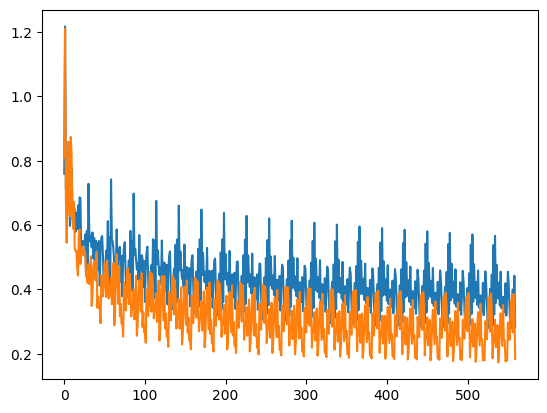

In [8]:
plt.plot(losses1, label='Control probe 1')
plt.plot(losses2, label='Control probe 2')

In [9]:
t.manual_seed(SEED)

probe = Probe(activation_dim).to(device)
opt = t.optim.AdamW(probe.parameters(), lr=lr)

# train on ambiguous data
for _ in range(epochs):
    for acts, f_labels, sp_labels in data['train']['ambiguous']['batches']:
        assert t.isclose(f_labels, sp_labels).all()
        acts, f_labels = acts.to(device), f_labels.to(device)
        opt.zero_grad()
        logits = probe(acts)
        loss = nn.BCELoss()(logits, f_labels.float())
        loss.backward()
        opt.step()

# compute accuracy on ambiguous test data
with t.no_grad():
    corrects = []
    for acts, f_labels, sp_labels in data['test']['ambiguous']['batches']:
        assert t.isclose(f_labels, sp_labels).all()
        acts, f_labels = acts.to(device), f_labels.to(device)
        probs = probe(acts)
        preds = probs.round()
        batch_corrects = (preds == f_labels).float()
        corrects.append(batch_corrects)
    acc = t.cat(corrects).mean().item()
    print(f'Accuracy on ambiguous data: {acc}')

# compute accuracy on unambiguous test data
    corrects1, corrects2 = [], []
    for acts, f_labels, sp_labels in data['test']['unambiguous']['batches']:
        acts, f_labels, sp_labels = acts.to(device), f_labels.to(device), sp_labels.to(device)

        probs = probe(acts)
        preds = probs.round()
        batch_corrects = (preds == f_labels).float()
        corrects1.append(batch_corrects)
        batch_corrects = (preds == sp_labels).float()
        corrects2.append(batch_corrects)
    
    acc1 = t.cat(corrects1).mean().item()
    acc2 = t.cat(corrects2).mean().item()
    print(f'Accuracy on unambiguous data feat1: {acc1}')
    print(f'Accuracy on unambiguous data feat2: {acc2}')


Accuracy on ambiguous data: 0.8530701994895935
Accuracy on unambiguous data feat1: 0.6370614171028137
Accuracy on unambiguous data feat2: 0.7160087823867798


In [10]:
batch_size = 8

submodules = []
for i in range(layer + 1):
    submodules.append(model.gpt_neox.layers[i].mlp)
    submodules.append(model.gpt_neox.layers[i].attention)
    submodules.append(model.gpt_neox.layers[i])

dictionaries = []
for i in range(layer + 1):
    ae = AutoEncoder(512, 64 * 512).to(device)
    ae.load_state_dict(t.load(f'/share/projects/dictionary_circuits/autoencoders/pythia-70m-deduped/mlp_out_layer{i}/5_32768/ae.pt'))
    dictionaries.append(ae)
    ae = AutoEncoder(512, 64 * 512).to(device)
    ae.load_state_dict(t.load(f'/share/projects/dictionary_circuits/autoencoders/pythia-70m-deduped/attn_out_layer{i}/5_32768/ae.pt'))
    dictionaries.append(ae)
    ae = AutoEncoder(512, 64 * 512).to(device)
    ae.load_state_dict(t.load(f'/share/projects/dictionary_circuits/autoencoders/pythia-70m-deduped/resid_out_layer{i}/5_32768/ae.pt'))
    dictionaries.append(ae)


def metric_fn(model):
    return probe(model.gpt_neox.layers[layer].output[0][:,-1,:])

inputs = data['train']['ambiguous']['statements']
labels = data['train']['ambiguous']['f_labels']
neg_inputs, pos_inputs = [], []
for x, label in zip(inputs, labels):
    if label == 0:
        neg_inputs.append(x)
    else:
        pos_inputs.append(x)

neg_effects, pos_effects = {}, {}
for i in range(0, len(neg_inputs), batch_size):
    neg_effects_batch, _ = patching_effect(
        neg_inputs[i:i+batch_size],
        None,
        model,
        submodules,
        dictionaries,
        metric_fn,
        method='separate'
    )
    for k, v in neg_effects_batch.items():
        if k not in neg_effects:
            neg_effects[k] = v.sum(dim=1).sum(dim=0)
        else:
            neg_effects[k] += v.sum(dim=1).sum(dim=0)
    neg_effects = {
        k : v / len(neg_inputs) for k, v in neg_effects.items()
    }

for i, submodule in enumerate(submodules):
    print(f"Layer {i // 3} {'mlp' if i % 3 == 0 else 'attention' if i % 3 == 1 else 'res stream'}:")
    effect = neg_effects[submodule]
    for feature_idx in t.nonzero(effect):
        value = effect[tuple(feature_idx)]
        if value > 0.001:
            print(f"    Multindex: {tuple(feature_idx.tolist())}, Value: {value}")

for i in range(0, len(pos_inputs), batch_size):
    pos_effects_batch, _ = patching_effect(
        pos_inputs[i:i+batch_size],
        None,
        model,
        submodules,
        dictionaries,
        metric_fn,
        method='separate'
    )
    for k, v in pos_effects_batch.items():
        if k not in pos_effects:
            pos_effects[k] = v.sum(dim=1).sum(dim=0)
        else:
            pos_effects[k] += v.sum(dim=1).sum(dim=0)
    pos_effects = {
        k : v / len(pos_inputs) for k, v in pos_effects.items()
    }

for i, submodule in enumerate(submodules):
    print(f"Layer {i // 3} {'mlp' if i % 3 == 0 else 'attention' if i % 3 == 1 else 'res stream'}:")
    effect = pos_effects[submodule]
    for feature_idx in t.nonzero(effect):
        value = effect[tuple(feature_idx)]
        if -value > 0.001:
            print(f"    Multindex: {tuple(feature_idx.tolist())}, Value: {value}")

# total_effects = {
#     k : -pos_effects[k] + neg_effects[k] for k in pos_effects.keys()
# }
# for i, submodule in enumerate(submodules):
#     print(f"Layer {i}:")
#     effect = total_effects[submodule]
#     for feature_idx in t.nonzero(effect):
#         value = effect[tuple(feature_idx)]
#         if value > 0.001:
#             print(f"    Multindex: {tuple(feature_idx.tolist())}, Value: {value}")

Layer 0 mlp:
Layer 0 attention:
Layer 0 res stream:
Layer 1 mlp:
Layer 1 attention:
Layer 1 res stream:
Layer 2 mlp:
    Multindex: (961,), Value: 0.0010529391001909971
    Multindex: (7445,), Value: 0.0012847958132624626
    Multindex: (26846,), Value: 0.0014830919681116939
Layer 2 attention:
Layer 2 res stream:
Layer 3 mlp:
Layer 3 attention:
Layer 3 res stream:
    Multindex: (12803,), Value: 0.0013393147382885218
Layer 4 mlp:
Layer 4 attention:
Layer 4 res stream:
Layer 0 mlp:
    Multindex: (27238,), Value: -0.001115503371693194
Layer 0 attention:
Layer 0 res stream:
Layer 1 mlp:
Layer 1 attention:
Layer 1 res stream:
    Multindex: (15975,), Value: -0.0013970622094348073
Layer 2 mlp:
Layer 2 attention:
Layer 2 res stream:
Layer 3 mlp:
Layer 3 attention:
Layer 3 res stream:
    Multindex: (13246,), Value: -0.0011455899802967906
Layer 4 mlp:
Layer 4 attention:
Layer 4 res stream:


In [77]:
component_idx = 11
feat_idx = 6326

submodule = submodules[component_idx]
dictionary = dictionaries[component_idx]

# interpret some features
buffer = ActivationBuffer(
    zst_to_generator('/share/data/datasets/pile/the-eye.eu/public/AI/pile/train/00.jsonl.zst'),
    model,
    [submodule],
    out_feats=512,
    in_batch_size=128,
    n_ctxs=512,
)

out = examine_dimension(
    model,
    submodule,
    buffer,
    dictionary,
    dim_idx=feat_idx,
)
print(out['top_tokens'])
out['top_contexts']

[('M', 15.154867172241211), ('N', 13.80984115600586), ('IN', 12.197416305541992), ('MAN', 11.26910400390625), ('IL', 9.90345287322998), ('J', 8.941851615905762), ('New', 8.548611640930176), ('NEW', 7.5246477127075195), ('Major', 7.082497596740723), (' YORK', 6.429671287536621)]


In [41]:
for statement in data['train']['ambiguous']['statements']:
    if 'syria' in statement:
        print(statement)

So is Canada about killing someone that leaves Islam? Is Canada about muslims marching on AL QUDS day chanting to kill jews? Is Canada about Imams telling the mosque to go kill Jews? Is Canada about Imams telling new syrians to kill infidels? Is Canada about Female Genital mutilation ? Is Canada about muslim men defending their right to have sex with 9 yrs olds? Is Canada about honor killings? Is Canada about Sharia law. ?  Is Canada about Imams suggesting we all wear burqas so we don't get raped? Your comment suggests we should all accept this behaviour from muslims Be sheep. be ok with this ---Sharia-ism - like communism and Nazism - destroys the rights of all people.  .https://youtu.be/Lc6GVg3GfuI ps this is the video of the man defending his right to have sex with 9 yr old adults.


In [71]:
effects, _ = patching_effect(
    "idiot",
    None,
    model,
    submodules,
    dictionaries,
    metric_fn,
    method='ig'
)
for i, submodule in enumerate(submodules):
    print(f"Layer {i // 3} {'mlp' if i % 3 == 0 else 'attention' if i % 3 == 1 else 'res stream'}:")
    effect = effects[submodule]
    for feature_idx in t.nonzero(effect):
        value = effect[tuple(feature_idx)]
        if value.abs() > 0.001:
            print(f"    Multindex: {tuple(feature_idx.tolist())}, Value: {value}")

Layer 0 mlp:
    Multindex: (0, 0, 4195), Value: -0.1950753778219223
    Multindex: (0, 1, 2525), Value: -0.3004608154296875
Layer 0 attention:
    Multindex: (0, 0, 721), Value: 0.0011276330333203077
    Multindex: (0, 0, 1375), Value: -0.001911412924528122
    Multindex: (0, 0, 1737), Value: -0.0029740752652287483
    Multindex: (0, 0, 2983), Value: -0.001323144999332726
    Multindex: (0, 0, 3008), Value: -0.0016803418984636664
    Multindex: (0, 0, 3753), Value: -0.0018149554962292314
    Multindex: (0, 0, 3846), Value: -0.001223154948092997
    Multindex: (0, 0, 4144), Value: 0.0049741207621991634
    Multindex: (0, 0, 4221), Value: 0.002831300487741828
    Multindex: (0, 0, 5414), Value: 0.002760804956778884
    Multindex: (0, 0, 5802), Value: 0.005073390901088715
    Multindex: (0, 0, 6103), Value: 0.0013206698931753635
    Multindex: (0, 0, 7123), Value: 0.0011302449274808168
    Multindex: (0, 0, 7399), Value: -0.002590390620753169
    Multindex: (0, 0, 7452), Value: 0.0127809

In [60]:
input = "Islam"

to_ablate = {
    submodule : [] for submodule in submodules
}
to_ablate[submodules[0]] = [9971]
to_ablate[submodules[11]] = [13246]


with model.invoke(input):
    acts = model.gpt_neox.layers[layer].output[0][:,-1,:].save()
acts = acts.value.clone()
pred_before = probe(acts).item()

with model.invoke(input):
    for submodule, dictionary in zip(submodules, dictionaries):
        x = submodule.output
        is_resid = type(x.shape) == tuple
        if is_resid:
            x = x[0]
        x_hat = dictionary(x)
        residual = x - x_hat
        
        f = dictionary.encode(x)
        ablation_idxs = to_ablate[submodule]
        for idx in ablation_idxs:
            f[..., idx] = 0
        x_hat = dictionary.decode(f)
        if is_resid:
            submodule.output[0][:] = x_hat + residual
        else:
            submodule.output = x_hat + residual
    acts = model.gpt_neox.layers[layer].output[0][:,-1,:].save()
acts = acts.value.clone()
pred_after = probe(acts).item()

print(f'before: {pred_before}, after: {pred_after}')

before: 0.9998002648353577, after: 0.9553442001342773


In [24]:
def get_acts(model):
    return model.gpt_neox.layers[layer].output[0][:,-1,:]

# get accuracy on ambiguous test set
inputs, labels = data_gen(ambiguous=True, split='test')
acts = run_with_ablations(
    model,
    inputs,
    submodules,
    dictionaries,
    to_ablate,
    get_acts,
)
preds = probe(acts.clone()).round()
acc = (preds == labels).float().mean().item()
print(f'Accuracy on ambiguous data: {acc}')

# get accuracy on unambiguous test set
inputs, feat1_labels, feat2_labels = data_gen(ambiguous=False, split='test')
acts = run_with_ablations(
    model,
    inputs,
    submodules,
    dictionaries,
    to_ablate,
    get_acts,
)
preds = probe(acts.clone()).round()
acc = (preds == feat1_labels).float().mean().item()
print(f'feat1 accuracy: {acc}')
preds = probe(acts.clone()).round()
acc = (preds == feat2_labels).float().mean().item()
print(f'feat2 accuracy: {acc}')


Accuracy on ambiguous data: 0.8540145754814148
feat1 accuracy: 0.6131386756896973
feat2 accuracy: 0.8175182342529297


In [25]:
# train probes on unambiguous data
inputs, feat1_labels, feat2_labels = data_gen(ambiguous=False, split='train')

acts = run_with_ablations(
    model,
    inputs,
    submodules,
    dictionaries,
    to_ablate,
    get_acts,
)
acts = acts.clone()

t.manual_seed(SEED)
probe1 = Probe(acts.shape[-1]).to(device)
probe2 = Probe(acts.shape[-1]).to(device)
opt1 = t.optim.AdamW(probe1.parameters(), lr=lr)
opt2 = t.optim.AdamW(probe2.parameters(), lr=lr)

for _ in range(epochs):
    opt1.zero_grad(), opt2.zero_grad()
    logits1 = probe1(acts)
    logits2 = probe2(acts)
    loss1 = nn.BCELoss()(logits1, feat1_labels.float())
    loss2 = nn.BCELoss()(logits2, feat2_labels.float())
    loss1.backward(), loss2.backward()
    opt1.step(), opt2.step()

# get accuracy on unambiguous test set
inputs, feat1_labels, feat2_labels = data_gen(ambiguous=False, split='test')
acts = run_with_ablations(
    model,
    inputs,
    submodules,
    dictionaries,
    to_ablate,
    get_acts,
)
acts = acts.clone()

probs1 = probe1(acts)
probs2 = probe2(acts)
preds1, preds2 = probs1.round(), probs2.round()
acc1 = (preds1 == feat1_labels).float().mean().item()
acc2 = (preds2 == feat2_labels).float().mean().item()

print(f'feat1 accuracy: {acc1}')
print(f'feat2 accuracy: {acc2}')


feat1 accuracy: 0.970802903175354
feat2 accuracy: 0.9781022071838379


In [26]:
# retrain probe on ablated model
t.manual_seed(SEED)
probe_new = Probe(512).to(device)
optimizer = t.optim.AdamW(probe_new.parameters(), lr=lr)

# train probe on ambiguous data
inputs, labels = data_gen(ambiguous=True, split='train')
acts = run_with_ablations(
    model,
    inputs,
    submodules,
    dictionaries,
    to_ablate,
    get_acts,
)
acts = acts.clone()

for _ in range(epochs):
    optimizer.zero_grad()
    probs = probe_new(acts)
    loss = nn.BCELoss()(probs, labels.float())
    loss.backward()
    optimizer.step()

# get accuracy on ambiguous test set
inputs, labels = data_gen(ambiguous=True, split='test')
acts = run_with_ablations(
    model,
    inputs,
    submodules,
    dictionaries,
    to_ablate,
    get_acts,
)
acts = acts.clone()
preds = probe_new(acts).round()
acc = (preds == labels).float().mean().item()
print(f'Accuracy on ambiguous data: {acc}')

# get accuracy on unambiguous test set
inputs, feat1_labels, feat2_labels = data_gen(ambiguous=False, split='test')
acts = run_with_ablations(
    model,
    inputs,
    submodules,
    dictionaries,
    to_ablate,
    get_acts,
)
acts = acts.clone()
preds = probe_new(acts).round()
acc = (preds == feat1_labels).float().mean().item()
print(f'feat1 accuracy: {acc}')
preds = probe_new(acts).round()
acc = (preds == feat2_labels).float().mean().item()
print(f'feat2 accuracy: {acc}')

Accuracy on ambiguous data: 1.0
feat1 accuracy: 0.6934306621551514
feat2 accuracy: 0.8540145754814148


In [30]:
# classify things based on the difference between the probe and probe_new predictions
inputs, labels = data_gen(ambiguous=True, split='test')

with model.invoke(inputs):
    acts = model.gpt_neox.layers[layer].output[0][:,-1,:].save()
acts = acts.value.clone()

acts_new = run_with_ablations(
    model,
    inputs,
    submodules,
    dictionaries,
    to_ablate,
    get_acts,
)
acts_new = acts_new.clone()

probs1 = probe(acts)
probs2 = probe_new(acts_new)
diffs = probs2 - probs1
preds = (probs1 + diffs * 1.5).round()
# preds = t.where(
#     diffs.abs() > .1,
#     (diffs > 0).float(),
#     probs2.round()
# )
acc = (preds == labels).float().mean().item()
print(f'Accuracy on ambiguous data: {acc}')

inputs, feat1_labels, feat2_labels = data_gen(ambiguous=False, split='test')

with model.invoke(inputs):
    acts = model.gpt_neox.layers[layer].output[0][:,-1,:].save()
acts = acts.value.clone()

acts_new = run_with_ablations(
    model,
    inputs,
    submodules,
    dictionaries,
    to_ablate,
    get_acts,
)
acts_new = acts_new.clone()

probs1 = probe(acts)
probs2 = probe_new(acts_new)
diffs = probs2 - probs1
preds = (probs1 + diffs * 1.5).round()
# preds = t.where(
#     diffs.abs() > .1,
#     (diffs > 0).float(),
#     probs2.round()
# )

acc = (preds == feat1_labels).float().mean().item()
print(f'feat1 accuracy: {acc}')
acc = (preds == feat2_labels).float().mean().item()
print(f'feat2 accuracy: {acc}')

Accuracy on ambiguous data: 1.0
feat1 accuracy: 0.8102189898490906
feat2 accuracy: 0.7372262477874756


In [95]:
for x, prob1, prob2, pred in zip(inputs, probs1, probs2, preds):
    print(x, pred.item(), prob1.item(), prob2.item())

beef 0.0 0.016130540519952774 0.10863903164863586
tomatoes 0.0 0.03816014900803566 0.07154987752437592
headphone 0.0 0.003303040750324726 0.0007086424739100039
ELECTRON 0.0 0.9881590604782104 0.3553202152252197
seatbelt 0.0 0.006384061183780432 0.009708733297884464
GOBLINS 1.0 0.9988961219787598 0.9887816309928894
TRAVELER 0.0 0.9647229909896851 0.5679333806037903
DANCE 0.0 0.955156683921814 0.3251132667064667
parrot 0.0 0.005869964137673378 0.003408553544431925
minerals 1.0 0.043913815170526505 0.4811966121196747
refugee 0.0 0.010072360746562481 0.04388377442955971
cabinet 0.0 0.02018699236214161 0.08012460172176361
RUG 0.0 0.8661546111106873 0.7274554967880249
doctor 0.0 0.0022117462940514088 0.00015221636567730457
cookies 1.0 0.13208810985088348 0.45985421538352966
bicycle 0.0 0.004572806879878044 0.028945647180080414
toothbrushes 1.0 0.08090445399284363 0.411687433719635
zoos 0.0 0.16232438385486603 0.06332612782716751
ROADS 1.0 0.9704778790473938 0.9718976616859436
butter 0.0 0.00

In [340]:
probs2 - probs1

tensor([ 3.6879e-02,  2.0250e-02, -1.3686e-04,  2.3178e-01,  1.6529e-03,
         6.6891e-02,  2.7669e-01,  1.0507e-01, -2.0387e-04,  9.0288e-02,
         1.3871e-01,  2.7971e-02,  2.8520e-01, -1.7768e-04,  2.1047e-01,
         5.7020e-02,  4.4652e-01, -2.1454e-02,  5.7701e-01,  2.8447e-02,
         8.5847e-02,  2.5172e-05,  1.0240e-02,  3.1668e-01,  1.2039e-01,
         3.1745e-01,  1.5877e-01,  2.4371e-03, -5.2675e-04,  1.5538e-01,
         1.2155e-01, -9.7485e-05,  2.5782e-02,  5.9511e-02,  7.9205e-02,
         2.8743e-02,  9.1319e-02,  5.9899e-02,  4.1422e-01,  2.7963e-01,
         3.3364e-02,  7.9152e-02,  7.3441e-03,  4.3555e-01, -3.0199e-04,
         6.6104e-03, -3.7750e-04, -4.0154e-04,  3.5560e-01,  5.5813e-02,
         2.9123e-04,  4.7253e-01,  2.7764e-01,  3.6436e-01, -3.0451e-02,
         7.5291e-02,  2.3076e-01,  1.6617e-01,  1.3763e-01,  3.0491e-01,
         3.5337e-01,  1.4857e-01, -3.3222e-04,  3.4590e-01,  2.2563e-02,
         4.7432e-01,  4.9966e-01,  3.7437e-01,  1.4

In [7]:
test_data = pd.read_json('/share/data/datasets/msgs/syntactic_category_lexical_content_the/test.jsonl', lines=True)

ling_accs, surface_accs = [], []
# get accuracy on test data
for batch_idx in range(len(test_data) // batch_size):
    inputs = test_data['sentence'][batch_idx * batch_size:(batch_idx + 1) * batch_size].tolist()
    ling_labels = test_data['linguistic_feature_label'][batch_idx * batch_size:(batch_idx + 1) * batch_size].tolist()
    surface_labels = test_data['surface_feature_label'][batch_idx * batch_size:(batch_idx + 1) * batch_size].tolist()

    with model.invoke(inputs) as invoker:
        hidden_states = model.gpt_neox.layers[-3].output[0].save()
    
    with t.no_grad():
        preds = probe(hidden_states.value)
        ling_acc = (preds.round() == t.Tensor(ling_labels).to('cuda:0')).float().mean()
        surface_acc = (preds.round() == t.Tensor(surface_labels).to('cuda:0')).float().mean()
        ling_accs.append(ling_acc.item())
        surface_accs.append(surface_acc.item())

print('ling acc:', sum(ling_accs) / len(ling_accs))
print('surface acc:', sum(surface_accs) / len(surface_accs))
    

ling acc: 0.9539930555555556
surface acc: 0.6663995726495726


In [8]:
from attribution import patching_effect
from dictionary_learning.dictionary import AutoEncoder

In [16]:
clean = "All grandsons do resemble the print and Debra is an organized child."
patch = "All grandsons do resemble a print and Debra is an banana child."

with model.invoke([clean, patch]) as invoker:
    hidden_states = model.gpt_neox.layers[-3].output[0].save()

with t.no_grad():
    preds = probe(hidden_states.value)
preds

tensor([0.4021, 0.0954], device='cuda:0')

In [17]:
def metric_fn(model):
    return probe(model.gpt_neox.layers[-3].output[0])

submodules = [
    model.gpt_neox.layers[i] for i in range(4)
] + [
    model.gpt_neox.layers[i].mlp for i in range(4)
]
dictionaries = []
for i in range(4):
    dictionary = AutoEncoder(512, 64 * 512).to(device)
    dictionary.load_state_dict(t.load(f'/share/projects/dictionary_circuits/autoencoders/pythia-70m-deduped/resid_out_layer{i}/0_32768/ae.pt'))
    dictionaries.append(dictionary)
for i in range(4):
    dictionary = AutoEncoder(512, 64 * 512).to(device)
    dictionary.load_state_dict(t.load(f'/share/projects/dictionary_circuits/autoencoders/pythia-70m-deduped/mlp_out_layer{i}/1_32768/ae.pt'))
    dictionaries.append(dictionary)

out = patching_effect(
    clean,
    patch,
    model,
    submodules,
    dictionaries,
    metric_fn,
)

In [19]:
effects, total_effect = out
print(f"Total effect: {total_effect}")
for layer, submodule in enumerate(submodules):
    print(f"Layer {layer}:")
    effect = effects[submodule]
    for feature_idx in t.nonzero(effect):
        value = effect[tuple(feature_idx)]
        if value.abs() > 0.1:
            print(f"    Multindex: {tuple(feature_idx.tolist())}, Value: {value}")

Total effect: tensor([-0.7627], device='cuda:0', grad_fn=<DivBackward0>)
Layer 0:
    Multindex: (0, 6, 23084), Value: -0.31019383668899536
    Multindex: (0, 6, 29115), Value: -0.2026602178812027
    Multindex: (0, 12, 9247), Value: 0.23665377497673035
    Multindex: (0, 12, 19133), Value: -0.13597454130649567
    Multindex: (0, 13, 1147), Value: 0.10391081869602203
    Multindex: (0, 13, 1256), Value: -0.12887312471866608
    Multindex: (0, 13, 3385), Value: -0.34761813282966614
    Multindex: (0, 13, 3613), Value: -0.11544839292764664
    Multindex: (0, 13, 5702), Value: -11.003226280212402
    Multindex: (0, 13, 5962), Value: -0.18838448822498322
    Multindex: (0, 13, 6959), Value: -0.9820340871810913
    Multindex: (0, 13, 15146), Value: -0.12887312471866608
    Multindex: (0, 13, 25951), Value: -0.24457168579101562
    Multindex: (0, 13, 26640), Value: -0.25634047389030457
    Multindex: (0, 13, 27692), Value: -0.12028089165687561
    Multindex: (0, 13, 31525), Value: -0.1246131

In [15]:
for i, tok in enumerate(invoker.input.input_ids[0]):
    print(f"{i}: {model.tokenizer.decode([tok])}")

0: All
1:  gr
2: ands
3: ons
4:  do
5:  resemble
6:  the
7:  print
8:  and
9:  De
10: bra
11:  is
12:  an
13:  organized
14:  child
15: .


In [ ]:
# to_ablate = {
#     submodules[0] : [
#         5650,
#         17126,
#         22182,
#         25864,
#         2655,
#         12249,
#         12267,
#         21248,
#         21329,
#     ],
#     submodules[1] : [
#         14465,
#         18471,
#         22990,
#         16629,
#         26134,
#         32267,
#     ],
#     submodules[2] : [
#         16421,
#         22968,
#         27888,
#         15899,
#         28262,
#         28306,
#         32164,
#     ]
# }